In [1131]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler


# from mlxtend.feature_selection import SequentialFeatureSelector 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.metrics import accuracy_score,mean_squared_error

import matplotlib.pyplot as plt

import statsmodels.api as sm

import seaborn as sns

from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_squared_error

In [1132]:
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [1133]:
data = pd.read_csv("BodyFat.csv")
print(data.isnull().sum())
data.describe()

IDNO         0
BODYFAT      0
DENSITY      0
AGE          0
WEIGHT       0
HEIGHT       0
ADIPOSITY    0
NECK         0
CHEST        0
ABDOMEN      0
HIP          0
THIGH        0
KNEE         0
ANKLE        0
BICEPS       0
FOREARM      0
WRIST        0
dtype: int64


,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,126.500000,18.938492,1.055574,44.884921,178.924405,70.148810,25.436905,37.992063,100.824206,92.555952,99.904762,59.405952,38.590476,23.102381,32.273413,28.663889,18.229762
std,72.890329,7.750856,0.019031,12.602040,29.389160,3.662856,3.648111,2.430913,8.430476,10.783077,7.164058,5.249952,2.411805,1.694893,3.021274,2.020691,0.933585
min,1.000000,0.000000,0.995000,22.000000,118.500000,29.500000,18.100000,31.100000,79.300000,69.400000,85.000000,47.200000,33.000000,19.100000,24.800000,21.000000,15.800000
25%,63.750000,12.800000,1.041400,35.750000,159.000000,68.250000,23.100000,36.400000,94.350000,84.575000,95.500000,56.000000,36.975000,22.000000,30.200000,27.300000,17.600000
50%,126.500000,19.000000,1.054900,43.000000,176.500000,70.000000,25.050000,38.000000,99.650000,90.950000,99.300000,59.000000,38.500000,22.800000,32.050000,28.700000,18.300000
75%,189.250000,24.600000,1.070400,54.000000,197.000000,72.250000,27.325000,39.425000,105.375000,99.325000,103.525000,62.350000,39.925000,24.000000,34.325000,30.000000,18.800000
max,252.000000,45.100000,1.108900,81.000000,363.150000,77.750000,48.900000,51.200000,136.200000,148.100000,147.700000,87.300000,49.100000,33.900000,45.000000,34.900000,21.400000


In [1134]:

ls = list(data.loc[:,"BODYFAT"])
ls.sort()
ls

[0.0,
 1.9,
 4.1,
 4.6,
 4.7,
 4.9,
 5.0,
 5.1,
 6.1,
 6.1,
 6.4,
 6.5,
 6.8,
 6.9,
 7.1,
 7.1,
 7.3,
 7.4,
 7.5,
 7.8,
 8.2,
 8.4,
 8.5,
 8.5,
 8.7,
 8.8,
 9.1,
 9.2,
 9.2,
 9.2,
 9.4,
 9.4,
 9.6,
 9.9,
 9.9,
 9.9,
 10.1,
 10.1,
 10.4,
 10.5,
 10.6,
 10.7,
 10.8,
 10.9,
 11.1,
 11.1,
 11.2,
 11.3,
 11.3,
 11.5,
 11.8,
 11.9,
 11.9,
 12.0,
 12.0,
 12.3,
 12.4,
 12.5,
 12.6,
 12.7,
 12.7,
 12.8,
 12.8,
 12.8,
 13.2,
 13.3,
 13.4,
 13.4,
 13.4,
 13.7,
 13.8,
 14.0,
 14.0,
 14.1,
 14.1,
 14.2,
 14.3,
 14.4,
 14.8,
 14.8,
 14.9,
 15.0,
 15.0,
 15.0,
 15.1,
 15.2,
 15.3,
 15.3,
 15.5,
 15.7,
 16.0,
 16.0,
 16.1,
 16.1,
 16.5,
 16.5,
 16.5,
 16.6,
 16.7,
 16.8,
 16.8,
 16.9,
 17.0,
 17.2,
 17.2,
 17.3,
 17.4,
 17.4,
 17.4,
 17.6,
 17.6,
 17.7,
 17.8,
 17.9,
 18.0,
 18.1,
 18.1,
 18.2,
 18.2,
 18.3,
 18.4,
 18.5,
 18.6,
 19.0,
 19.0,
 19.0,
 19.0,
 19.1,
 19.1,
 19.3,
 19.3,
 19.5,
 19.8,
 19.8,
 20.0,
 20.1,
 20.1,
 20.1,
 20.1,
 20.2,
 20.2,
 20.2,
 20.4,
 20.5,
 20.5,
 20.5,
 20.6,
 20.8,


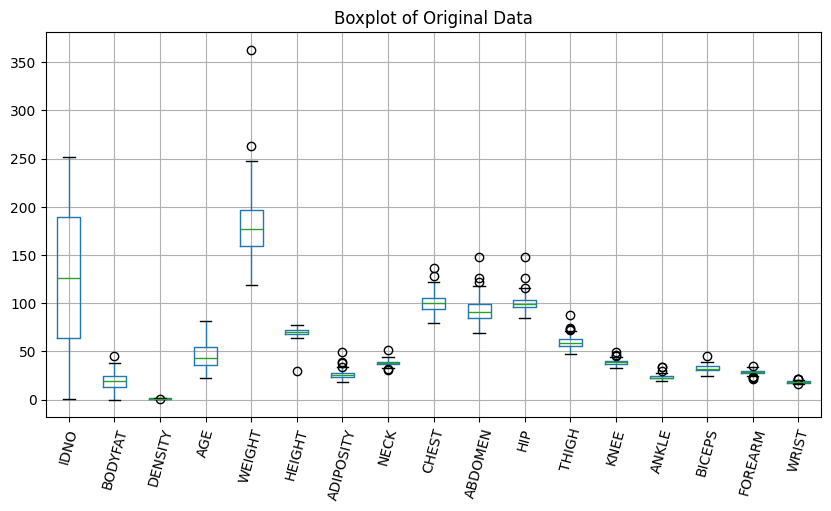

In [1135]:
df = pd.DataFrame(data)
plt.figure(figsize=(10, 5))
df.boxplot()
plt.title('Boxplot of Original Data')
plt.xticks(rotation=75)
plt.show()



### Remove outliers

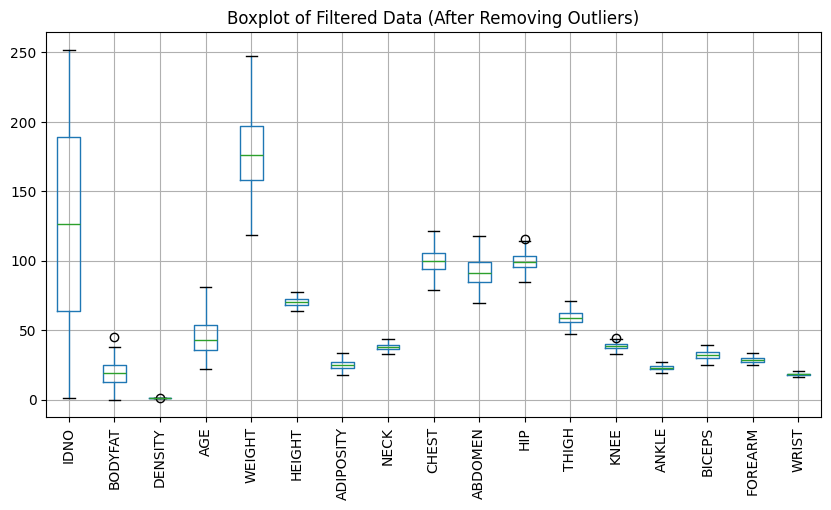

In [1136]:
filtered_columns = [col for col in data.columns if col not in ["IDNO","BODYFAT","DENSITY","AGE"]]
df_removed = df.copy()
for column in filtered_columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    df_removed[column] = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)][column]


plt.figure(figsize=(10, 5))
df_removed.boxplot()
plt.xticks(rotation=90)
plt.title('Boxplot of Filtered Data (After Removing Outliers)')
plt.show()

In [1137]:
df_removed.describe()
# X = df_removed.drop(columns=["IDNO","BODYFAT","DENSITY","ADIPOSITY"])
X = df_removed.drop(columns=["IDNO","BODYFAT","DENSITY"])
y = df_removed["BODYFAT"]
print("X missing data:\n",X.isnull().sum())
print("y missing data:\n",y.isnull().sum())

X missing data:
 AGE          0
WEIGHT       2
HEIGHT       1
ADIPOSITY    4
NECK         3
CHEST        2
ABDOMEN      3
HIP          3
THIGH        4
KNEE         3
ANKLE        3
BICEPS       1
FOREARM      5
WRIST        4
dtype: int64
y missing data:
 0


### K-fold searching for k

经高人指点，kfold的模型选取用knn模型预测，这样避免了特征选取的问题

In [1138]:
pipeline = Pipeline(steps=[
    ('scaler', MinMaxScaler()),
    ('imputer', KNNImputer()),  
    ('model',KNeighborsRegressor())  
])

param_grid = {
    'imputer__n_neighbors': [ 3,5,7,9, 11, 13, 15, 17, 19, 21, 25]  
}

kf = KFold(n_splits=5, shuffle=True, random_state=42)
#kf = KFold(n_splits=5, shuffle=True)
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=kf, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

print("Best n_neighbors:", grid_search.best_params_)

Best n_neighbors: {'imputer__n_neighbors': 3}


## Imputation

In [1139]:
imputer = KNNImputer(n_neighbors=3)
df_imputed = pd.DataFrame(imputer.fit_transform(df_removed), columns=df_removed.columns)


# scaler = MinMaxScaler()
# scaler.fit(df_imputed)
# df_imputed_scaled = pd.DataFrame(scaler.transform(df_imputed),columns=df_imputed.columns)

# df_imputed_scaled.describe()

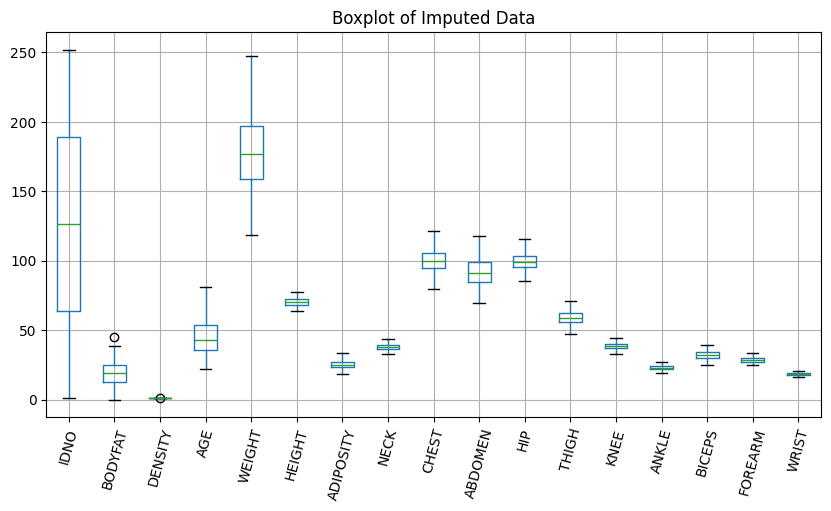

In [1140]:
plt.figure(figsize=(10, 5))
df_imputed.boxplot()
plt.title('Boxplot of Imputed Data')
plt.xticks(rotation=75)
plt.show()

### Dealing with BMI calculating problem(not solved)

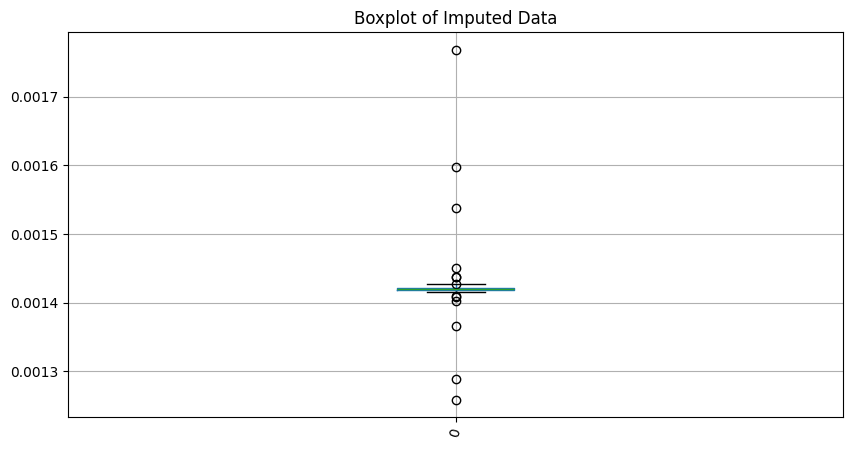

In [1141]:
ratio = (df_imputed["WEIGHT"]/df_imputed["HEIGHT"]**2)/df_imputed["ADIPOSITY"]
pd.DataFrame(ratio).describe()
plt.figure(figsize=(10, 5))
pd.DataFrame(ratio).boxplot()
plt.title('Boxplot of Imputed Data')
plt.xticks(rotation=75)
plt.show()

$$ratio = \frac{\frac{Weight}{Height^2}}{bmi}$$
正常情况下这一列的取值应该保持一致，如果不是傻逼的英制单位这个值应该是1
$$1kg = 2.2046lb $$
$$1m = 39.3701in$$
$$\frac{1kg}{1m^2}=\frac{2.2046lb}{(39.3701in)^2}=0.001422\frac{lb}{in^2}$$
现在成0.001422左右了

In [1142]:
ratio_df = pd.DataFrame(ratio)


outliers_index = []


for col in ratio_df.columns:
    Q1 = ratio_df[col].quantile(0.25)  
    Q3 = ratio_df[col].quantile(0.75)  
    IQR = Q3 - Q1  
    
    lower_bound = Q1 - 1.5 * IQR  
    upper_bound = Q3 + 1.5 * IQR  
    

    outliers = ratio_df[(ratio_df[col] < lower_bound) | (ratio_df[col] > upper_bound)].index
    outliers_index.extend(outliers.tolist()) 


outliers_index = sorted(set(outliers_index))  
print(f"All Outliers Index: {outliers_index}")

All Outliers Index: [38, 40, 41, 45, 60, 85, 115, 155, 162, 215, 220, 234, 241]


In [1143]:
handle = df_imputed.iloc[outliers_index,:]
handle

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
38,39.0,33.8,1.0202,46.0,208.333333,72.250000,30.966667,39.033333,111.366667,107.866667,110.700000,66.533333,41.0,25.1,35.566667,29.0,18.033333
40,41.0,33.1,1.0217,45.0,210.666667,68.750000,30.733333,43.200000,111.566667,107.866667,107.533333,64.666667,39.6,26.6,36.400000,32.7,18.500000
41,42.0,31.7,1.0250,44.0,205.000000,70.833333,29.900000,36.600000,106.000000,104.300000,115.500000,70.600000,42.5,23.7,33.600000,28.7,17.400000
45,46.0,14.1,1.0670,43.0,164.250000,73.250000,21.300000,35.700000,96.600000,81.500000,97.200000,58.400000,38.2,23.4,29.700000,27.4,18.300000
60,61.0,25.4,1.0396,62.0,216.000000,73.250000,28.200000,41.400000,112.300000,104.800000,103.100000,61.600000,40.9,23.1,36.200000,31.8,20.200000
85,86.0,25.8,1.0386,67.0,167.000000,67.500000,26.000000,36.500000,98.900000,89.700000,96.200000,54.700000,37.8,23.7,32.400000,27.7,18.200000
115,116.0,16.7,1.0607,40.0,158.000000,69.250000,23.400000,36.300000,97.000000,86.600000,92.600000,55.900000,36.3,22.1,29.800000,26.3,17.300000
155,156.0,17.2,1.0594,28.0,171.500000,75.250000,21.600000,35.600000,92.100000,83.500000,98.300000,57.300000,37.8,21.7,32.200000,27.7,17.700000
162,163.0,13.3,1.0690,33.0,184.250000,68.750000,24.400000,40.700000,98.900000,92.100000,103.500000,64.000000,37.3,23.5,33.500000,30.6,19.700000
215,216.0,45.1,0.9950,51.0,219.000000,64.000000,30.233333,41.200000,119.800000,109.433333,112.800000,62.500000,36.9,23.6,34.700000,29.1,18.400000


In [1144]:
mean_height = df_imputed['HEIGHT'].mean()
std_height = df_imputed['HEIGHT'].std()
mean_weight = df_imputed['WEIGHT'].mean()
std_weight =df_imputed['WEIGHT'].std()


handle['zscore_height'] = (handle['HEIGHT'] - mean_height) / std_height
handle['zscore_weight'] = (handle['WEIGHT'] - mean_weight) / std_weight
transform = 0.001422

def recalculate_values(row):
    if abs(row['zscore_height']) > abs(row['zscore_weight']):
        new_height = np.sqrt(row['WEIGHT'] / (row['ADIPOSITY']*transform))
        return new_height, row['WEIGHT']  
    else:
        new_weight = row['ADIPOSITY'] * (row['HEIGHT'] ** 2)*transform
        return row['HEIGHT'], new_weight  

handle = pd.DataFrame(handle)
handle[['new_height', 'new_weight']] = handle.apply(recalculate_values, axis=1, result_type='expand')

handle['HEIGHT'] = handle['new_height']
handle['WEIGHT'] = handle['new_weight']

handle.drop(columns=['zscore_height', 'zscore_weight', 'new_height', 'new_weight'], inplace=True)
handle

E:\新建文件夹 (2)\ipykernel_16432\1115884418.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  handle['zscore_height'] = (handle['HEIGHT'] - mean_height) / std_height
E:\新建文件夹 (2)\ipykernel_16432\1115884418.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  handle['zscore_weight'] = (handle['WEIGHT'] - mean_weight) / std_weight


,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
38,39.0,33.8,1.0202,46.0,229.863364,72.250000,30.966667,39.033333,111.366667,107.866667,110.700000,66.533333,41.0,25.1,35.566667,29.0,18.033333
40,41.0,33.1,1.0217,45.0,206.564016,68.750000,30.733333,43.200000,111.566667,107.866667,107.533333,64.666667,39.6,26.6,36.400000,32.7,18.500000
41,42.0,31.7,1.0250,44.0,213.327156,70.833333,29.900000,36.600000,106.000000,104.300000,115.500000,70.600000,42.5,23.7,33.600000,28.7,17.400000
45,46.0,14.1,1.0670,43.0,164.250000,73.639883,21.300000,35.700000,96.600000,81.500000,97.200000,58.400000,38.2,23.4,29.700000,27.4,18.300000
60,61.0,25.4,1.0396,62.0,215.161202,73.250000,28.200000,41.400000,112.300000,104.800000,103.100000,61.600000,40.9,23.1,36.200000,31.8,20.200000
85,86.0,25.8,1.0386,67.0,167.000000,67.208123,26.000000,36.500000,98.900000,89.700000,96.200000,54.700000,37.8,23.7,32.400000,27.7,18.200000
115,116.0,16.7,1.0607,40.0,159.571383,69.250000,23.400000,36.300000,97.000000,86.600000,92.600000,55.900000,36.3,22.1,29.800000,26.3,17.300000
155,156.0,17.2,1.0594,28.0,171.500000,74.723187,21.600000,35.600000,92.100000,83.500000,98.300000,57.300000,37.8,21.7,32.200000,27.7,17.700000
162,163.0,13.3,1.0690,33.0,184.250000,72.871723,24.400000,40.700000,98.900000,92.100000,103.500000,64.000000,37.3,23.5,33.500000,30.6,19.700000
215,216.0,45.1,0.9950,51.0,219.000000,71.372226,30.233333,41.200000,119.800000,109.433333,112.800000,62.500000,36.9,23.6,34.700000,29.1,18.400000


In [1145]:
df_imputed.set_index('IDNO', inplace=True)
handle.set_index('IDNO', inplace=True)

df_imputed.update(handle)

df_imputed.reset_index(inplace=True)
df_imputed.describe()

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,126.500000,18.938492,1.055574,44.884921,178.220200,70.358114,25.293122,37.977249,100.659259,92.273280,99.659921,59.233730,38.531614,23.002249,32.235979,28.728968,18.202513
std,72.890329,7.750856,0.019031,12.602040,26.596980,2.580330,3.152763,2.216135,7.997167,9.945788,6.288671,4.777915,2.261546,1.341561,2.919694,1.833343,0.865377
min,1.000000,0.000000,0.995000,22.000000,118.500000,64.000000,18.100000,32.800000,79.300000,69.400000,85.000000,47.200000,33.000000,19.100000,24.800000,24.600000,16.100000
25%,63.750000,12.800000,1.041400,35.750000,159.491037,68.437500,23.100000,36.400000,94.350000,84.575000,95.500000,56.000000,36.975000,22.000000,30.200000,27.300000,17.600000
50%,126.500000,19.000000,1.054900,43.000000,176.500000,70.250000,25.050000,38.000000,99.650000,90.950000,99.300000,59.000000,38.500000,22.800000,32.050000,28.750000,18.300000
75%,189.250000,24.600000,1.070400,54.000000,197.000000,72.250000,27.325000,39.400000,105.375000,99.325000,103.525000,62.350000,39.925000,24.000000,34.325000,30.000000,18.800000
max,252.000000,45.100000,1.108900,81.000000,247.250000,77.750000,33.300000,43.900000,121.600000,118.000000,115.500000,71.200000,44.200000,27.000000,39.100000,33.800000,20.400000


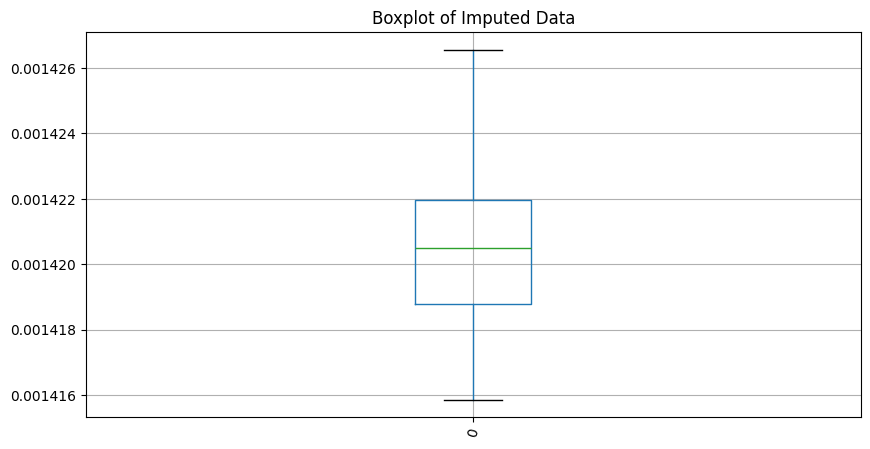

In [1146]:
ratio = (df_imputed["WEIGHT"]/df_imputed["HEIGHT"]**2)/df_imputed["ADIPOSITY"]

plt.figure(figsize=(10, 5))
pd.DataFrame(ratio).boxplot()
plt.title('Boxplot of Imputed Data')
plt.xticks(rotation=75)
plt.show()

In [1147]:
df_imputed

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,1.0,12.6,1.0708,23.0,154.25,67.75,23.7,36.2,93.1,85.2,94.5,59.0,37.3,21.9,32.0,27.4,17.100000
1,2.0,6.9,1.0853,22.0,173.25,72.25,23.4,38.5,93.6,83.0,98.7,58.7,37.3,23.4,30.5,28.9,18.200000
2,3.0,24.6,1.0414,22.0,154.00,66.25,24.7,34.0,95.8,87.9,99.2,59.6,38.9,24.0,28.8,25.2,16.600000
3,4.0,10.9,1.0751,26.0,184.75,72.25,24.9,37.4,101.8,86.4,101.2,60.1,37.3,22.8,32.4,29.4,18.200000
4,5.0,27.8,1.0340,24.0,184.25,71.25,25.6,34.4,97.3,100.0,101.9,63.2,42.2,24.0,32.2,27.7,17.700000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,248.0,11.5,1.0736,70.0,134.25,67.00,21.1,34.9,89.2,83.6,88.8,49.6,34.8,21.5,25.6,25.7,18.500000
248,249.0,32.3,1.0236,72.0,201.00,69.75,29.1,40.9,108.5,105.0,104.5,59.6,40.8,23.2,35.2,28.6,20.100000
249,250.0,28.3,1.0328,72.0,186.75,66.00,30.2,38.9,111.1,111.5,101.7,60.3,37.3,21.5,31.3,27.2,18.000000
250,251.0,25.3,1.0399,72.0,190.75,70.50,27.0,38.9,108.3,101.3,97.8,56.0,41.6,22.7,30.5,29.4,19.800000


In [1148]:
df_imputed["BFP"] =495/(1.0324 - 0.19077*np.log10(df_imputed["ABDOMEN"]-df_imputed["NECK"]) + 0.15456*np.log10(df_imputed["HEIGHT"]*2.54))-450


df_selected = df_imputed[['BFP', 'BODYFAT']]

print(df_selected)

           BFP  BODYFAT
0    18.964172     12.6
1    13.563255      6.9
2    23.177797     24.6
3    17.054111     10.9
4    28.387153     27.8
..         ...      ...
247  19.070122     11.5
248  28.161548     32.3
249  34.729108     28.3
250  26.805188     25.3
251  30.149899     30.7

[252 rows x 2 columns]


In [1149]:
# scaler = MinMaxScaler()
# scaler.fit(df_imputed)
# df_imputed_scaled = pd.DataFrame(scaler.transform(df_imputed),columns=df_imputed.columns)

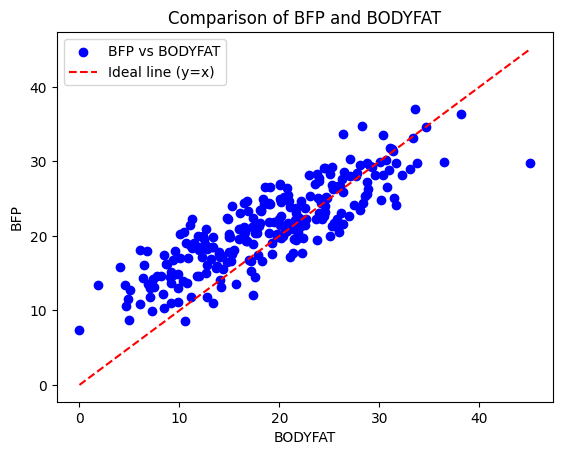

In [1150]:
plt.scatter(df_imputed['BODYFAT'], df_imputed['BFP'], color='blue', label='BFP vs BODYFAT')

plt.title('Comparison of BFP and BODYFAT')
plt.xlabel('BODYFAT')
plt.ylabel('BFP')


plt.plot([df_imputed['BODYFAT'].min(), df_imputed['BODYFAT'].max()], 
         [df_imputed['BODYFAT'].min(), df_imputed['BODYFAT'].max()], 
         color='red', linestyle='--', label='Ideal line (y=x)')

plt.legend()

plt.show()

In [1151]:

df_selected['Residual'] = df_selected['BFP'] - df_selected['BODYFAT']


df_selected['Abs_Residual'] = np.abs(df_selected['Residual']/df_selected['BFP'])


df_sorted_by_residual = df_selected.sort_values(by='Abs_Residual', ascending=False)


print(df_sorted_by_residual.head(20))


# extreme_bodyfat = df_selected[(df_selected['BODYFAT'] > df_selected['BODYFAT'].quantile(0.95)) |
#                               (df_selected['BODYFAT'] < df_selected['BODYFAT'].quantile(0.05))]


# print(extreme_bodyfat)

           BFP  BODYFAT   Residual  Abs_Residual
181   7.387405      0.0   7.387405      1.000000
171  13.475084      1.9  11.575084      0.858999
170  15.769513      4.1  11.669513      0.740005
223  18.119572      6.1  12.019572      0.663347
25   13.460939      4.6   8.860939      0.658270
203  17.951415      6.8  11.151415      0.621200
8    12.786235      5.1   7.686235      0.601134
31   16.101865      6.5   9.601865      0.596320
54   11.539065      4.9   6.639065      0.575356
28   10.620067      4.7   5.920067      0.557442
47   14.292400      6.4   7.892400      0.552210
215  29.845961     45.1 -15.254039      0.511092
11   17.374351      8.5   8.874351      0.510773
96   20.284783     10.1  10.184783      0.502090
224  22.262937     11.3  10.962937      0.492430
1    13.563255      6.9   6.663255      0.491273
157  20.491289     10.5   9.991289      0.487587
230  21.488007     11.1  10.388007      0.483433
51   14.170372      7.4   6.770372      0.477784
210  14.597292      

E:\新建文件夹 (2)\ipykernel_16432\1391125929.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Residual'] = df_selected['BFP'] - df_selected['BODYFAT']
E:\新建文件夹 (2)\ipykernel_16432\1391125929.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected['Abs_Residual'] = np.abs(df_selected['Residual']/df_selected['BFP'])


In [1152]:
high_residual_ids = df_sorted_by_residual[df_sorted_by_residual['Abs_Residual'] > 0.5].index


df_imputed.loc[high_residual_ids, 'BODYFAT'] = df_imputed.loc[high_residual_ids, 'BFP']

df_imputed = df_imputed.drop(columns=["BFP"])

df_imputed.describe()

,IDNO,BODYFAT,DENSITY,AGE,WEIGHT,HEIGHT,ADIPOSITY,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,126.500000,19.352018,1.055574,44.884921,178.220200,70.358114,25.293122,37.977249,100.659259,92.273280,99.659921,59.233730,38.531614,23.002249,32.235979,28.728968,18.202513
std,72.890329,7.026949,0.019031,12.602040,26.596980,2.580330,3.152763,2.216135,7.997167,9.945788,6.288671,4.777915,2.261546,1.341561,2.919694,1.833343,0.865377
min,1.000000,5.000000,0.995000,22.000000,118.500000,64.000000,18.100000,32.800000,79.300000,69.400000,85.000000,47.200000,33.000000,19.100000,24.800000,24.600000,16.100000
25%,63.750000,13.775000,1.041400,35.750000,159.491037,68.437500,23.100000,36.400000,94.350000,84.575000,95.500000,56.000000,36.975000,22.000000,30.200000,27.300000,17.600000
50%,126.500000,19.050000,1.054900,43.000000,176.500000,70.250000,25.050000,38.000000,99.650000,90.950000,99.300000,59.000000,38.500000,22.800000,32.050000,28.750000,18.300000
75%,189.250000,24.600000,1.070400,54.000000,197.000000,72.250000,27.325000,39.400000,105.375000,99.325000,103.525000,62.350000,39.925000,24.000000,34.325000,30.000000,18.800000
max,252.000000,38.200000,1.108900,81.000000,247.250000,77.750000,33.300000,43.900000,121.600000,118.000000,115.500000,71.200000,44.200000,27.000000,39.100000,33.800000,20.400000


实际上这个比值离群点很多，要么是因为插值，要么是因为原本计算有误

In [1153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression



## SCALED

In [1154]:
scaler = MinMaxScaler()
scaler.fit(df_imputed)
df_imputed_scaled = pd.DataFrame(scaler.transform(df_imputed),columns=df_imputed.columns)

## Step-wise Selection

In [1155]:
def forward_selection(X, y, significance_level=0.05):
    initial_features = []
    remaining_features = list(X.columns)
    while remaining_features:
        p_values = pd.Series(index=remaining_features, dtype=float)
        for feature in remaining_features:
            model = sm.OLS(y, sm.add_constant(X[initial_features + [feature]])).fit()
            p_values[feature] = model.pvalues[feature]
        min_p_value = p_values.min()
        if min_p_value < significance_level:
            best_feature = p_values.idxmin()
            initial_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            break
    return initial_features

In [1156]:
def backward_selection(X, y, significance_level=0.05):
    features = list(X.columns) 
    while len(features) > 0:
        model = sm.OLS(y, X[features]).fit()
        p_values = model.pvalues
        max_p_value = p_values.max()
        if max_p_value > significance_level:
            excluded_feature = p_values.idxmax()
            print(f"Removing {excluded_feature} with p-value {max_p_value}")
            features.remove(excluded_feature)
        else:
            break
    return features

In [1157]:
from sklearn.feature_selection import SequentialFeatureSelector as SFS

In [1158]:
X_imputed = df_imputed.drop(columns=["IDNO","BODYFAT","DENSITY"])
y = df_imputed["BODYFAT"]

model = LinearRegression()

sfs = SFS(model, n_features_to_select='auto', direction='forward',cv=None)
sfs.fit(X_imputed , y)

selected_features = sfs.get_support()
# print("Selected features (by index):", selected_features)
X_selected = X_imputed.loc[:, selected_features]   

print("Selected features matrix:\n", X_selected.columns)

Selected features matrix:
 Index(['AGE', 'HEIGHT', 'CHEST', 'ABDOMEN', 'ANKLE', 'BICEPS', 'WRIST'], dtype='object')


In [1159]:
X_imputed_scaled = df_imputed_scaled.drop(columns=["IDNO","BODYFAT","DENSITY"])
y = df_imputed["BODYFAT"]

model = LinearRegression()

sfs = SFS(model, n_features_to_select='auto', direction='backward',cv=5)
sfs.fit(X_imputed_scaled , y)

selected_features = sfs.get_support()
# print("Selected features (by index):", selected_features)
X_selected = X_imputed_scaled.loc[:, selected_features]   

print("Selected features matrix:\n", X_selected.columns)

Selected features matrix:
 Index(['AGE', 'ADIPOSITY', 'NECK', 'CHEST', 'ABDOMEN', 'KNEE', 'WRIST'], dtype='object')


In [1160]:
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.05, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() 
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.idxmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [1161]:
result_forward = forward_selection(X_imputed_scaled , y)
result_forward

['ABDOMEN', 'WRIST', 'HEIGHT']

In [1162]:
result_backward = backward_selection(X_imputed_scaled , y)
result_backward

Removing HIP with p-value 0.6762759155144384
Removing FOREARM with p-value 0.45761928801511
Removing THIGH with p-value 0.25472585531672615
Removing ANKLE with p-value 0.2199113445346132
Removing KNEE with p-value 0.2653350739180759
Removing BICEPS with p-value 0.1376144732400702
Removing NECK with p-value 0.16957377187370518
Removing AGE with p-value 0.0681955567844914
Removing CHEST with p-value 0.14183611234744717


['WEIGHT', 'HEIGHT', 'ADIPOSITY', 'ABDOMEN', 'WRIST']

In [1163]:
output_stepwise = stepwise_selection(X_imputed_scaled , y)
result_stepwise = output_stepwise
result_stepwise

Add  ABDOMEN                        with p-value 1.18831e-62
Add  WRIST                          with p-value 5.15806e-09
Add  HEIGHT                         with p-value 0.000205753


['ABDOMEN', 'WRIST', 'HEIGHT']

In [1164]:
# from mlxtend.feature_selection import SequentialFeatureSelector

# linreg = LinearRegression()

# sfs = SequentialFeatureSelector(linreg, forward=True, k_features='best', scoring='r2', cv=5)
# sfs.fit(X_imputed_scaled, y)

# sfs.k_feature_names_

In [1165]:
# linreg = LinearRegression()

# sfs = SequentialFeatureSelector(linreg, forward=False, k_features='best', scoring='r2', cv=None)
# sfs.fit(X_imputed_scaled, y)

# sfs.k_feature_names_

## Visualization

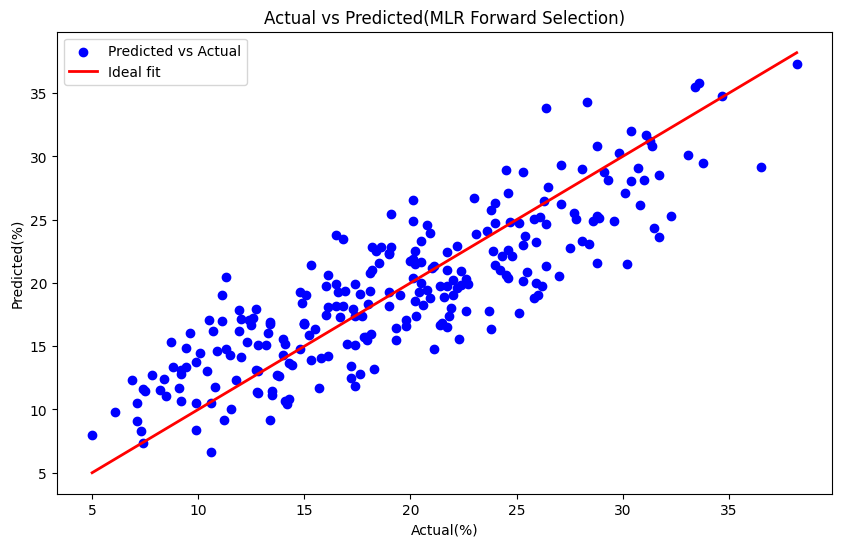

Mean Squared Error: 13.252105195324283


In [1166]:
X_forward = X_imputed_scaled.loc[:, result_forward]
X_backward = X_imputed_scaled.loc[:, result_backward]
X_stepwise = X_imputed_scaled.loc[:, result_stepwise] 

model = LinearRegression()

model.fit(X_forward,y)

y_pred = model.predict(X_forward)


plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2, label='Ideal fit')
plt.xlabel('Actual(%)')
plt.ylabel('Predicted(%)')
plt.title('Actual vs Predicted(MLR Forward Selection)')
plt.legend()

plt.show()


print("Mean Squared Error:", mean_squared_error(y, y_pred))

In [1167]:
cv_scores = cross_val_score(model, X_forward, y, cv=5, scoring='neg_mean_squared_error')

cv_mse_scores = -cv_scores

print("Cross-Validation MSE for each fold:", cv_mse_scores)

print("Average MSE from Cross-Validation:", cv_mse_scores.mean())

Cross-Validation MSE for each fold: [11.95447138 15.92298371 13.68570267 11.34269566 16.32925513]
Average MSE from Cross-Validation: 13.84702170931244


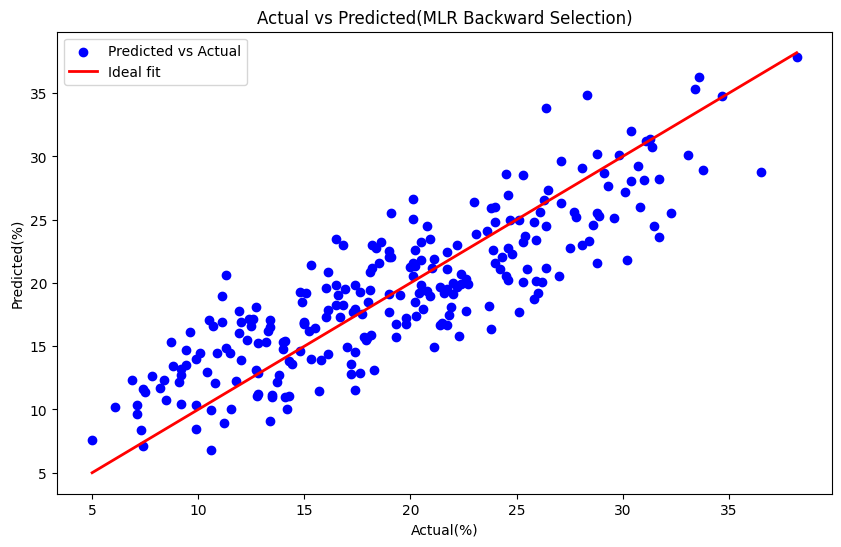

Mean Squared Error: 13.199131821357087


In [1168]:
model = LinearRegression()

model.fit(X_backward,y)

y_pred = model.predict(X_backward)


plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2, label='Ideal fit')
plt.xlabel('Actual(%)')
plt.ylabel('Predicted(%)')
plt.title('Actual vs Predicted(MLR Backward Selection)')
plt.legend()

plt.show()


print("Mean Squared Error:", mean_squared_error(y, y_pred))

In [1169]:
cv_scores = cross_val_score(model, X_backward, y, cv=5, scoring='neg_mean_squared_error')

cv_mse_scores = -cv_scores

print("Cross-Validation MSE for each fold:", cv_mse_scores)

print("Average MSE from Cross-Validation:", cv_mse_scores.mean())

Cross-Validation MSE for each fold: [12.23941095 16.06641717 13.90203552 11.1732157  16.6684032 ]
Average MSE from Cross-Validation: 14.009896508341715


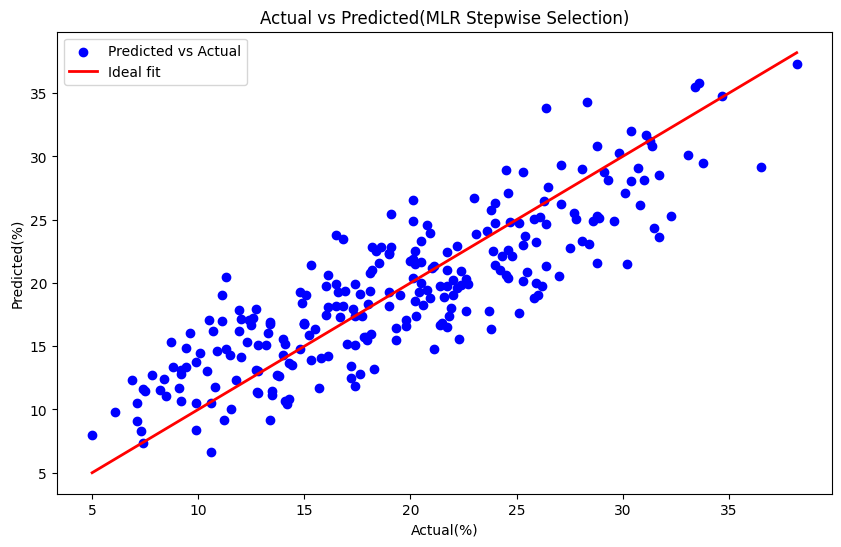

Mean Squared Error: 13.252105195324283


In [1170]:
model = LinearRegression()

model.fit(X_stepwise,y)

y_pred = model.predict(X_stepwise)

plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='blue', label='Predicted vs Actual')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2, label='Ideal fit')
plt.xlabel('Actual(%)')
plt.ylabel('Predicted(%)')
plt.title('Actual vs Predicted(MLR Stepwise Selection)')
plt.legend()

plt.show()


print("Mean Squared Error:", mean_squared_error(y, y_pred))

In [1171]:
cv_scores = cross_val_score(model, X_stepwise, y, cv=5, scoring='neg_mean_squared_error')

cv_mse_scores = -cv_scores

print("Cross-Validation MSE for each fold:", cv_mse_scores)

print("Average MSE from Cross-Validation:", cv_mse_scores.mean())

Cross-Validation MSE for each fold: [11.95447138 15.92298371 13.68570267 11.34269566 16.32925513]
Average MSE from Cross-Validation: 13.84702170931244


In [1172]:
X_with_const = sm.add_constant(X_forward)  
ols_model = sm.OLS(y, X_with_const)
results = ols_model.fit()


print("forward:",results.summary())

forward:                             OLS Regression Results                            
Dep. Variable:                BODYFAT   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.727
Method:                 Least Squares   F-statistic:                     224.1
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           2.58e-70
Time:                        17:50:56   Log-Likelihood:                -683.18
No. Observations:                 252   AIC:                             1374.
Df Residuals:                     248   BIC:                             1388.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.4284      0.755     12.482

In [1173]:
X_with_const = sm.add_constant(X_backward)  
ols_model = sm.OLS(y, X_with_const)
results = ols_model.fit()


print("stepwise:",results.summary())

stepwise:                             OLS Regression Results                            
Dep. Variable:                BODYFAT   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     134.1
Date:                Fri, 11 Oct 2024   Prob (F-statistic):           3.56e-68
Time:                        17:50:56   Log-Likelihood:                -682.67
No. Observations:                 252   AIC:                             1377.
Df Residuals:                     246   BIC:                             1399.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3717      3.353      2.19

## Decision Tree

In [1174]:
from sklearn.tree import DecisionTreeRegressor, plot_tree ,export_text

X = df_imputed_scaled.drop(columns=["IDNO","BODYFAT","DENSITY"])
y = df_imputed["BODYFAT"]

tree_model = DecisionTreeRegressor(max_depth=None)
tree_model.fit(X, y)

importances = tree_model.feature_importances_

In [1175]:
feature_names = X.columns if isinstance(X, pd.DataFrame) else [f"Feature {i}" for i in range(X.shape[1])]
# for feature, importance in zip(feature_names, importances):
#     print(f"{feature}: {importance}")

In [1176]:
feature_importance_dict = {feature: importance for feature, importance in zip(feature_names, importances)}


sorted_feature_importance = dict(sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True))


print("Sorted feature importance:")
for feature, importance in sorted_feature_importance.items():
    print(f"{feature}: {importance}")

Sorted feature importance:
ABDOMEN: 0.7023732966542854
NECK: 0.036431196169197926
WRIST: 0.03442657397258945
WEIGHT: 0.034129604516033155
BICEPS: 0.033532814368986405
THIGH: 0.03010310508657687
AGE: 0.028694356180887216
ANKLE: 0.024522798941363874
HIP: 0.02086673650874717
HEIGHT: 0.019948045255484676
CHEST: 0.014730767809485538
KNEE: 0.012790307913854538
FOREARM: 0.005573937748067823
ADIPOSITY: 0.0018764588744399873


In [1177]:
sorted_feature_names = [feature for feature, importance in sorted_feature_importance.items()][:6]

sorted_feature_names

['ABDOMEN', 'NECK', 'WRIST', 'WEIGHT', 'BICEPS', 'THIGH']

In [1178]:
X_tree_selected = X[sorted_feature_names]
X_tree_selected

,ABDOMEN,NECK,WRIST,WEIGHT,BICEPS,THIGH
0,0.325103,0.306306,0.232558,0.277670,0.503497,0.491667
1,0.279835,0.513514,0.488372,0.425243,0.398601,0.479167
2,0.380658,0.108108,0.116279,0.275728,0.279720,0.516667
3,0.349794,0.414414,0.488372,0.514563,0.531469,0.537500
4,0.629630,0.144144,0.372093,0.510680,0.517483,0.666667
...,...,...,...,...,...,...
247,0.292181,0.189189,0.558140,0.122330,0.055944,0.100000
248,0.732510,0.729730,0.930233,0.640777,0.727273,0.516667
249,0.866255,0.549550,0.441860,0.530097,0.454545,0.545833
250,0.656379,0.549550,0.860465,0.561165,0.398601,0.366667


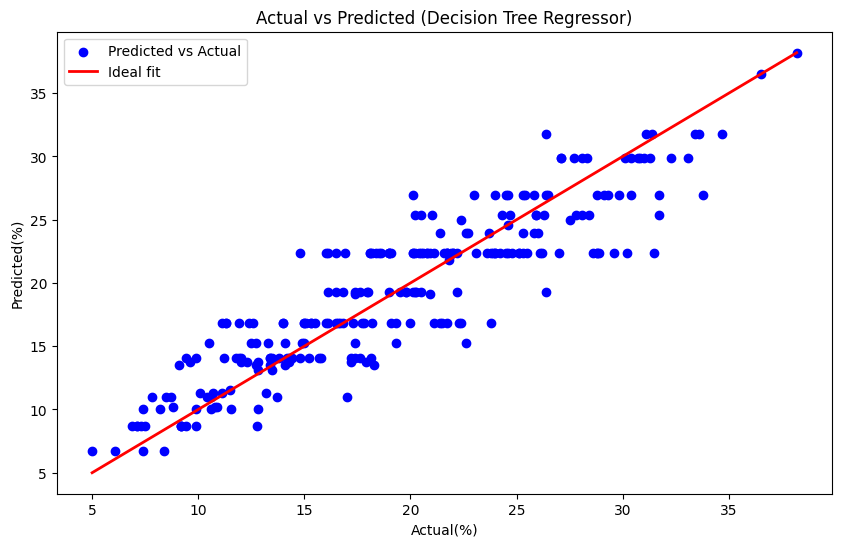

In [1179]:
tree_model = DecisionTreeRegressor(max_depth=5)
tree_model.fit(X_tree_selected, y)

y_pred = tree_model.predict(X_tree_selected)


plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='blue', label='Predicted vs Actual')

plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', lw=2, label='Ideal fit')

plt.xlabel('Actual(%)')
plt.ylabel('Predicted(%)')
plt.title('Actual vs Predicted (Decision Tree Regressor)')
plt.legend()

plt.show()

# mse = mean_squared_error(y, y_pred)
# print(f"Mean Squared Error (MSE): {mse}")

In [1180]:
cv_scores = cross_val_score(tree_model, X_tree_selected, y, cv=5, scoring='neg_mean_squared_error')

cv_mse_scores = -cv_scores

print("Cross-Validation MSE for each fold:", cv_mse_scores)

print("Average MSE from Cross-Validation:", cv_mse_scores.mean())

Cross-Validation MSE for each fold: [23.14082317 24.61214404 37.42641046 25.51117647 27.23865151]
Average MSE from Cross-Validation: 27.585841128338483


In [1182]:
tree_rules = export_text(tree_model, feature_names=list(X_tree_selected.columns))
print(tree_rules)

|--- ABDOMEN <= 0.40
|   |--- ABDOMEN <= 0.30
|   |   |--- BICEPS <= 0.21
|   |   |   |--- BICEPS <= 0.06
|   |   |   |   |--- THIGH <= 0.11
|   |   |   |   |   |--- value: [11.50]
|   |   |   |   |--- THIGH >  0.11
|   |   |   |   |   |--- value: [13.14]
|   |   |   |--- BICEPS >  0.06
|   |   |   |   |--- BICEPS <= 0.15
|   |   |   |   |   |--- value: [6.72]
|   |   |   |   |--- BICEPS >  0.15
|   |   |   |   |   |--- value: [10.07]
|   |   |--- BICEPS >  0.21
|   |   |   |--- WRIST <= 0.44
|   |   |   |   |--- THIGH <= 0.19
|   |   |   |   |   |--- value: [10.96]
|   |   |   |   |--- THIGH >  0.19
|   |   |   |   |   |--- value: [14.04]
|   |   |   |--- WRIST >  0.44
|   |   |   |   |--- BICEPS <= 0.36
|   |   |   |   |   |--- value: [13.52]
|   |   |   |   |--- BICEPS >  0.36
|   |   |   |   |   |--- value: [8.69]
|   |--- ABDOMEN >  0.30
|   |   |--- NECK <= 0.14
|   |   |   |--- ABDOMEN <= 0.39
|   |   |   |   |--- value: [24.60]
|   |   |   |--- ABDOMEN >  0.39
|   |   |   |   |